In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from qkeras import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns

2022-11-16 21:55:29.511987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 21:55:29.658687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 21:55:29.658727: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-16 21:55:29.680607: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 21:55:30.300166: W tensorflow/stream_executor/platform/de

In [2]:
train_df = pd.read_csv('train_1Dy.csv',nrows=1000000)
test_df = pd.read_csv('test_1Dy.csv',nrows=50000)

In [3]:
X_train = train_df.drop(columns=['y-midplane','cotBeta']).values
X_test = test_df.drop(columns=['y-midplane','cotBeta']).values

y_train = train_df['y-midplane'].values
y_test = test_df['y-midplane'].values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [5]:
def custom_loss(y, p):
    
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma1 = 0.1+tf.math.softplus(tf.gather(params=p, indices=[1], axis=1))
    sigma2 = 0.1+tf.math.softplus(tf.gather(params=p, indices=[2], axis=1))
    A = 1+tf.math.softplus(tf.gather(params=p, indices=[3], axis=1))
    
    norm1 = tf.math.sqrt(2*pi)*sigma1
    norm2 = tf.math.sqrt(2*pi)*sigma2
    
    normtot = norm1 + A*norm2
        
    term1 = tf.math.exp(-0.5*(y-mu)*(y-mu)/(sigma1*sigma1))
    term2 = tf.math.exp(-0.5*(y-mu)*(y-mu)/(sigma2*sigma2))
    
    likelihood = (term1 + A*term2)/normtot
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [6]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    #x = BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(4, name="dense2")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss=custom_loss)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                896       
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 dense2 (Dense)              (None, 4)                 260       
                                                                 
Total params: 1,156
Trainable params: 1,156
Non-trainable params: 0
_________________________________________________________________


2022-11-16 21:08:26.867210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 21:08:26.867625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 21:08:26.867696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-16 21:08:26.867754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-16 21:08:26.867817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [7]:
es = EarlyStopping(patience=10,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=500, 
                    batch_size=4096,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/500
196/196 [==============================] - 2s 5ms/step - loss: 11.1871 - val_loss: 5.4552
Epoch 2/500
196/196 [==============================] - 1s 5ms/step - loss: 4.2191 - val_loss: 3.6021
Epoch 3/500
196/196 [==============================] - 1s 7ms/step - loss: 3.3774 - val_loss: 3.2159
Epoch 4/500
196/196 [==============================] - 1s 6ms/step - loss: 3.1331 - val_loss: 3.0660
Epoch 5/500
196/196 [==============================] - 1s 4ms/step - loss: 3.0212 - val_loss: 2.9795
Epoch 6/500
196/196 [==============================] - 1s 3ms/step - loss: 2.9442 - val_loss: 2.9077
Epoch 7/500
196/196 [==============================] - 1s 3ms/step - loss: 2.8736 - val_loss: 2.8363
Epoch 8/500
196/196 [==============================] - 1s 5ms/step - loss: 2.8014 - val_loss: 2.7631
Epoch 9/500
196/196 [==============================] - 1s 3ms/step - loss: 2.7308 - val_loss: 2.6939
Epoch 10/500
196/196 [==============================] - 1s 6ms/step - loss: 2.6622 - val_l

/tmp/ipykernel_183903/4052347745.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


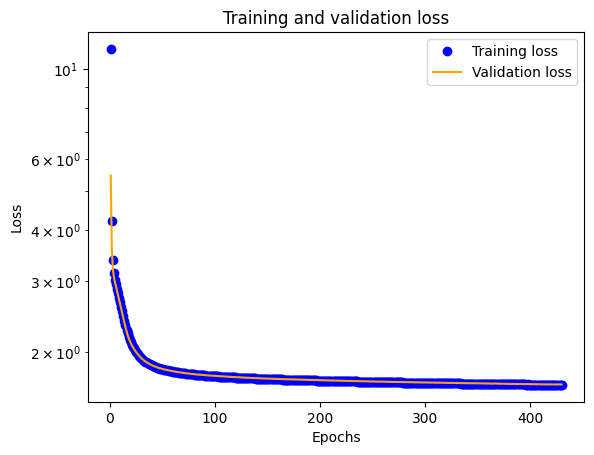

In [8]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()

In [9]:
model.save('models_1Dy/doublegauss.keras')

In [10]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma1','sigma2','A'])
df['sigma1'] = 0.1 + tf.math.softplus(df['sigma1'])
df['sigma2'] = 0.1 + tf.math.softplus(df['sigma2'])
df['A'] = 1 + tf.math.softplus(df['A'])
df['ytrue'] = y_test
df.to_csv("test_1DyDoubleGauss.csv",header=False,index=False)

1563/1563 [==============================] - 1s 719us/step


In [11]:
residuals = y_test - p_test[:,0]

/tmp/ipykernel_183903/1263665479.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


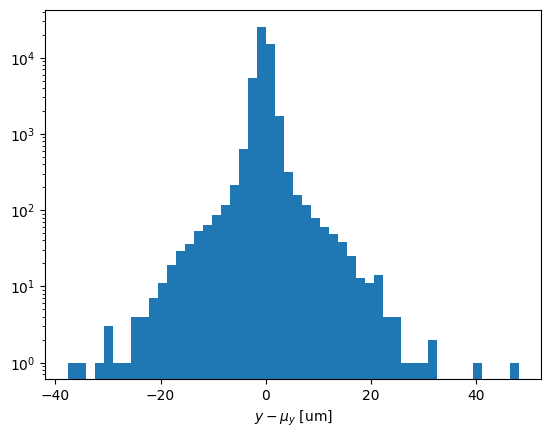

/tmp/ipykernel_183903/1263665479.py:7: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


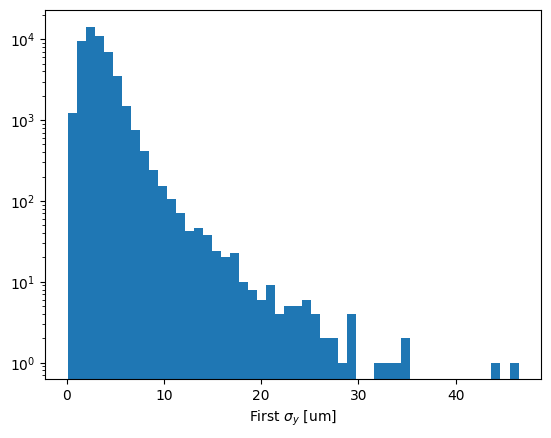

/tmp/ipykernel_183903/1263665479.py:12: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


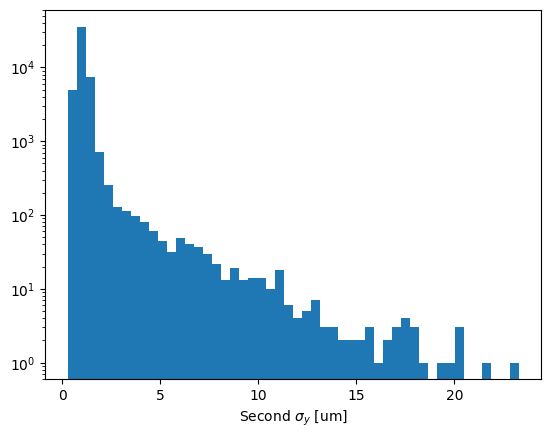

/tmp/ipykernel_183903/1263665479.py:17: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


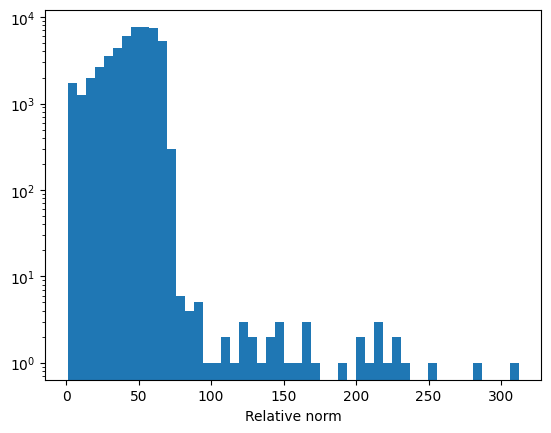

In [13]:
plt.hist(residuals,bins=50)
plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')
plt.show()

plt.hist(df['sigma1'],bins=50);
plt.yscale('Log')
plt.xlabel(r'First $\sigma_y$ [um]')
plt.show()

plt.hist(df['sigma2'],bins=50);
plt.yscale('Log')
plt.xlabel(r'Second $\sigma_y$ [um]')
plt.show()

plt.hist(df['A'],bins=50);
plt.yscale('Log')
plt.xlabel(r'Relative norm')
plt.show()

In [14]:
pulls = residuals/p_test[:,1]

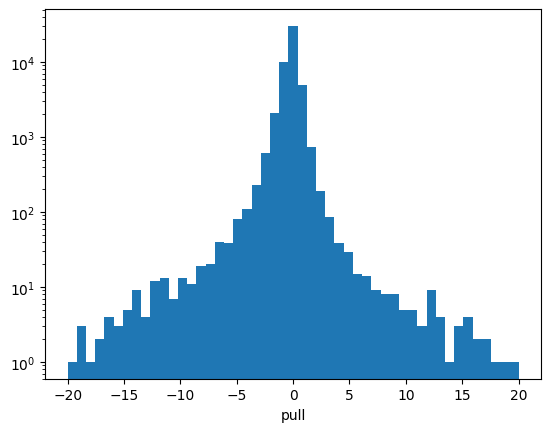

In [15]:
plt.hist(pulls,bins=np.linspace(-20,20,50));
plt.xlabel('pull')
plt.yscale('log')

In [16]:
print(np.mean(pulls),np.std(pulls))

-0.23312229517163988 13.696048193173676


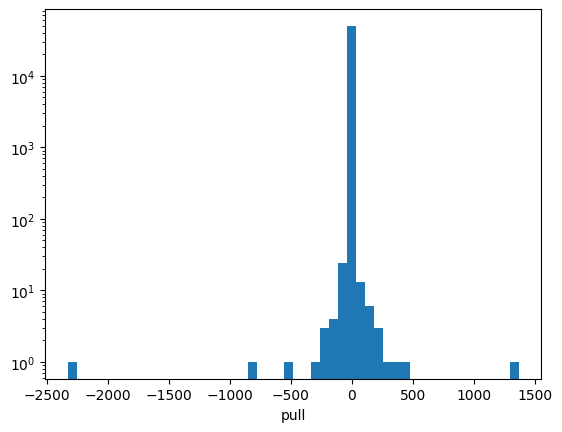

In [17]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')
plt.yscale('log')

Text(0, 0.5, '$y-\\mu_y$ [um]')

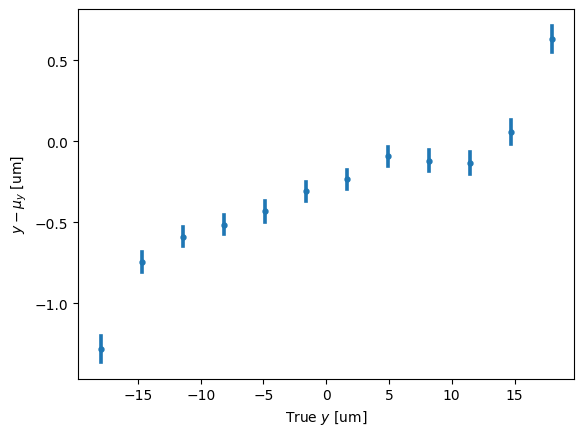

In [20]:
x = sns.regplot(x=df['ytrue'], y=df['ytrue']-df['mu'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.')
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$y-\mu_y$ [um]')

In [1]:
y = sns.regplot(x=df['ytrue'], y=df['sigma1'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.')
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$\sigma_y$ [um]')

NameError: name 'sns' is not defined

In [4]:
df_1d_gauss = pd.read_csv('test_1DyGauss.csv',header=None,names=['mu','sigma','ytrue'])
df_1d_doublegauss = pd.read_csv('test_1DyDoubleGauss.csv',header=None,names=['mu','sigma1','sigma2','A','ytrue'])

Text(0.5, 0, '$\\mu_y$ [um]')

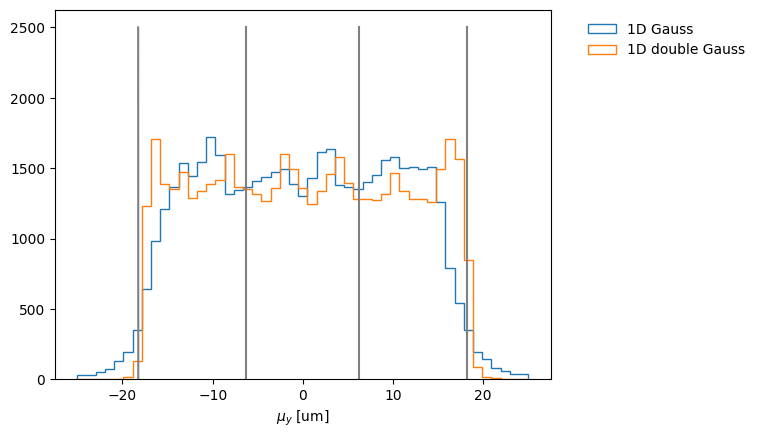

In [9]:
plt.hist(df_1d_gauss['mu'],histtype='step',bins=np.linspace(-25,25,50),label=r'1D Gauss');
plt.hist(df_1d_doublegauss['mu'],histtype='step',bins=np.linspace(-25,25,50),label=r'1D double Gauss');

plt.plot([-18.25,-18.26],[0,2500],color='gray')
plt.plot([-6.25,-6.25],[0,2500],color='gray')
plt.plot([6.25,6.25],[0,2500],color='gray')
plt.plot([18.25,18.25],[0,2500],color='gray')

plt.legend(frameon=False,bbox_to_anchor=(1.05,1))
plt.xlabel(r'$\mu_y$ [um]')

Text(0.5, 0, '$\\mu_y-y$ [um]')

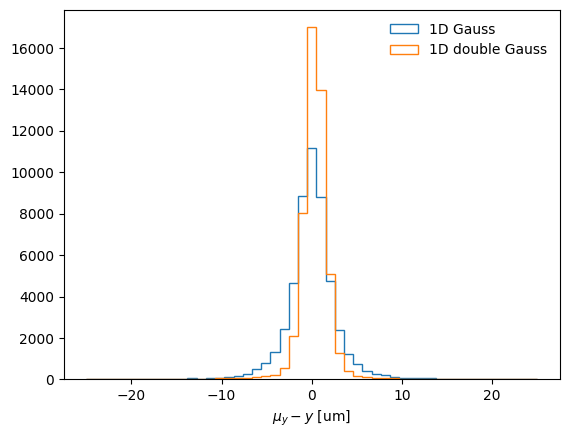

In [13]:
plt.hist(df_1d_gauss['mu']-df_1d_gauss['ytrue'],histtype='step',bins=np.linspace(-25,25,50),label=r'1D Gauss');
plt.hist(df_1d_doublegauss['mu']-df_1d_doublegauss['ytrue'],histtype='step',bins=np.linspace(-25,25,50),label=r'1D double Gauss');

plt.legend(frameon=False)
plt.xlabel(r'$\mu_y-y$ [um]')

Text(0.5, 0, '$\\sigma_y$ [um]')

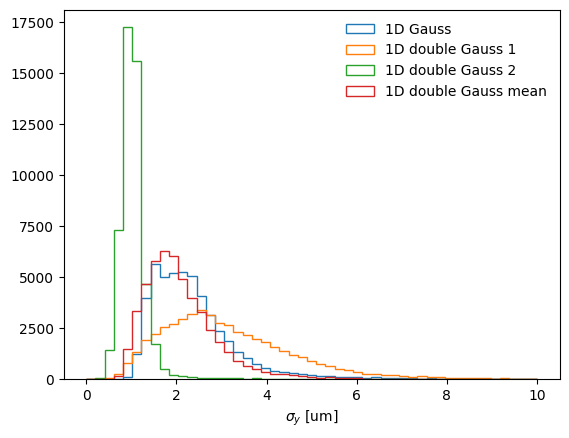

In [17]:
plt.hist(df_1d_gauss['sigma'],histtype='step',bins=np.linspace(0,10,50),label=r'1D Gauss');
plt.hist(df_1d_doublegauss['sigma1'],histtype='step',bins=np.linspace(0,10,50),label=r'1D double Gauss 1');
plt.hist(df_1d_doublegauss['sigma2'],histtype='step',bins=np.linspace(0,10,50),label=r'1D double Gauss 2');
plt.hist((df_1d_doublegauss['sigma1']+df_1d_doublegauss['sigma2'])/2,histtype='step',bins=np.linspace(0,10,50),label=r'1D double Gauss mean');

plt.legend(frameon=False)
plt.xlabel(r'$\sigma_y$ [um]')